# RGI11 (Central Europe)

F. Roura-Adseiras & Fabien Maussion

Goal:
- Alps: updates of the Paul 2003 dataset
- Pytrenees: new inventory by Izagirre

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, find_duplicates, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest
reg = 11

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# Izaguirre file for GLIMS check 
ref_reg_file_p = os.path.join(data_dir, 'l0_support_data', 'pyrenees2000.zip') 

# Frank file for GLIMS check 
ref_reg_file_a = os.path.join(data_dir, 'l0_support_data', 'C3S_GI_RGI11_L5_2003.zip') 

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '11_rgi60_CentralEurope.zip')

In [3]:
# Support data
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the GLIMS input data

In [4]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [5]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
1,41,7.4,Taschner,Ranzi,2006,Italian Alps,2001,2001,2001
301,5,3.3,Taschner,Ranzi,2006,Italian Alps,2003,2003,2003
501,45,2.3,Iacovelli,Ranzi,2006,Italian Alps,2003,2003,2003
531,132,37.0,"Rott, Schicker, Schwaizer (nee Bippus)",Rott,2008,Austrian Alps,2003,2003,2003
532,155,61.0,"Schicker, Schwaizer (nee Bippus)",Rott,2008,Austrian Alps,1985,1985,1985
533,896,896.8,Paul,Paul,2009,Swiss Alps,1998,1998,1998
558,10,8.5,Vantadori,Ranzi,2012,Italian Alps,2007,2007,2007
568,660,302.4,Rabatel,Rabatel,2013,French Alps,2003,2003,2004
569,537,343.0,Rabatel,Rabatel,2013,French Alps,1985,1985,1988


In [6]:
# # Optional: write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', f'rgi{reg:02d}_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi{reg:02d}_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), f'rgi{reg:02d}_inventories']))

## Outline selection 

In [7]:
# For Alps we use 'subm_id' = 731 as our main dataset
RGI_a = shp.loc[shp['subm_id'] == 731].copy()

# Sel by size
print(len(RGI_a))
RGI_a = size_filter(RGI_a)
len(RGI_a)

4060


4042

In [8]:
# For Pyrenees we use 'subm_id' = 715 as our main dataset
RGI_p = shp.loc[shp['subm_id'] == 715].copy()

# Sel by size
print(len(RGI_p))
RGI_p = size_filter(RGI_p)
len(RGI_p)

47


45

In [9]:
# combine the geodataframes
rgi7 = pd.concat([RGI_a, RGI_p])
rgi7['is_rgi6'] = False

### Some sanity checks 

In [10]:
dupes = find_duplicates(rgi7)

Seems Okay!


In [11]:
rgi7 = correct_geoms(rgi7)

Found 65 invalid geometries out of 4087. Correcting...
After correction, 0 geometries are still invalid.
Area changed by 41.0 m2 (0.0000%)


In [12]:
needs_size_filter(rgi7)

False

In [13]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
731,4042,4042
715,45,45


In [14]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

### Plots 

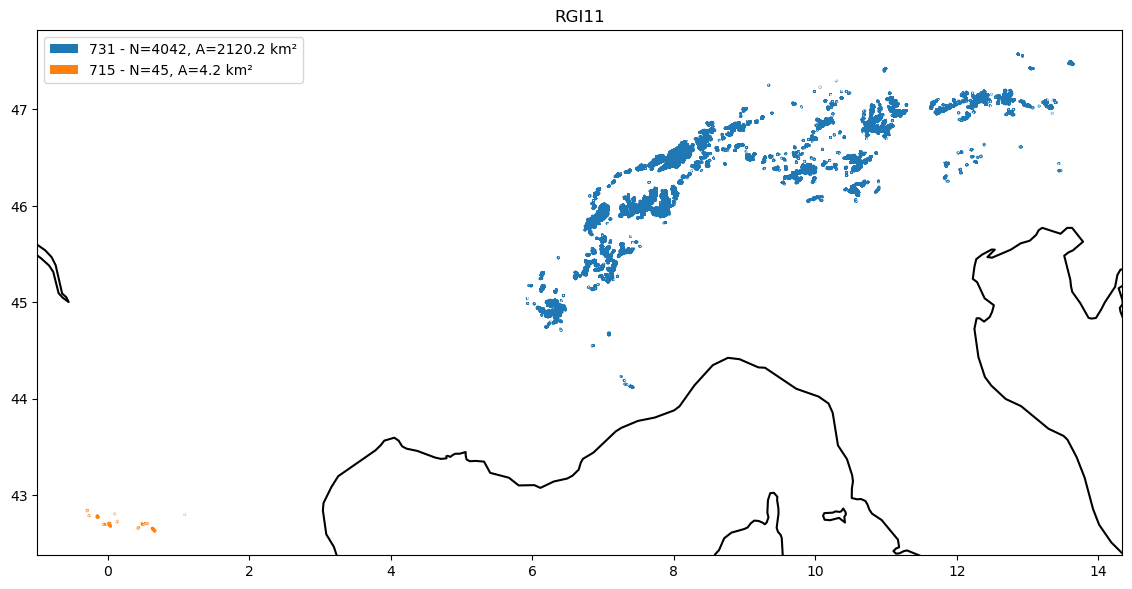

In [15]:
plot_map(rgi7, reg, loc='upper left', linewidth=2)

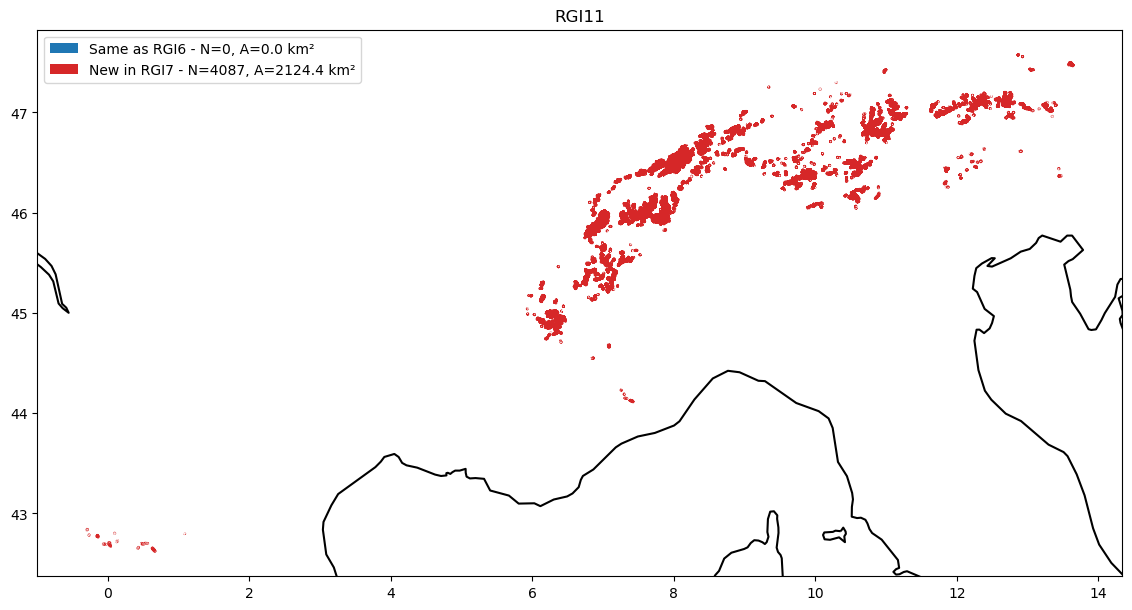

In [16]:
plot_map(rgi7, reg, loc='upper left', linewidth=2, is_rgi6=True)

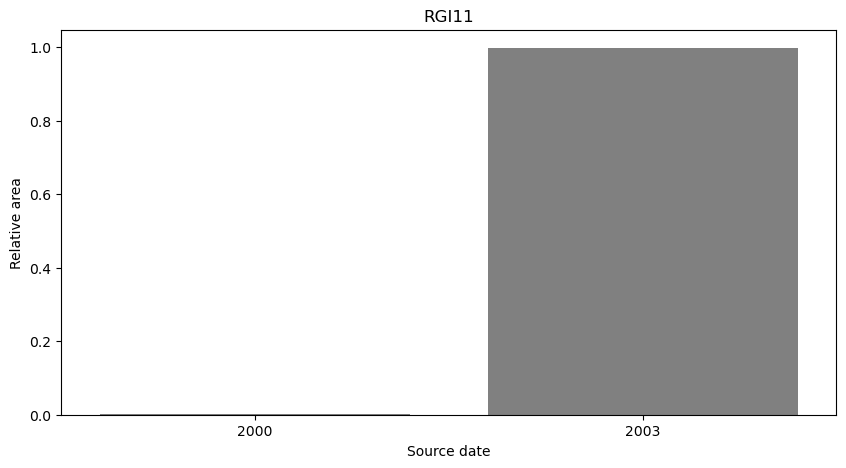

In [17]:
plot_date_hist(rgi7, reg)

### Text for github

In [18]:
fgh = sdf.T
fgh

subm_id,731,715
N,4042,45
A,2120.2,4.2
analysts,"Frey, Le Bris, Paul, Rastner",Izagirre
submitters,Paul,Izagirre
release_date,2021,2020
geog_area,Swiss Alps,Pyrenees
src_date_mode,2003,2000
src_date_min,2003,2000
src_date_max,2003,2000


In [19]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 731                          | 715      |
|:--------------|:-----------------------------|:---------|
| N             | 4042                         | 45       |
| A             | 2120.2                       | 4.2      |
| analysts      | Frey, Le Bris, Paul, Rastner | Izagirre |
| submitters    | Paul                         | Izagirre |
| release_date  | 2021                         | 2020     |
| geog_area     | Swiss Alps                   | Pyrenees |
| src_date_mode | 2003                         | 2000     |
| src_date_min  | 2003                         | 2000     |
| src_date_max  | 2003                         | 2000     |


## Write out and tar 

In [20]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI11/
RGI11/RGI11.shx
RGI11/RGI11.prj
RGI11/RGI11.cpg
RGI11/RGI11.shp
RGI11/RGI11.dbf
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI11.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI11'], returncode=0)


## New RGI-file created - Check result!

Load reference data (here RGI6 and the original contributions) to enable comparison

In [18]:
# load reference data
from utils import open_zip_shapefile
ref_rgi6 = open_zip_shapefile(rgi6_reg_file)

# Al
ref_a = open_zip_shapefile(os.path.join(support_dir, 'C3S_GI_RGI11_L5_2003.zip'))

# Py
ref_p = open_zip_shapefile(os.path.join(support_dir, 'pyrenees2000.zip'), exclude_pattern='__MACOSX', include_pattern='glaciers_')

### Compare new RGI7-file to RGI6

#### Number of elements (differences do not necessarily depict problems)

In [19]:
print('Number of glaciers in new RGI:', len(rgi7))
print('Number of glaciers in RGI6:', len(ref_rgi6))
print('Difference:', len(rgi7)-len(ref_rgi6))

Number of glaciers in new RGI: 4087
Number of glaciers in RGI6: 3927
Difference: 160


### How many nominal glaciers were there in RGI06?

In [20]:
len(ref_rgi6.loc[ref_rgi6.Status == 2])

2

### Total area

In [21]:
# add an area field to RGI_ss and reference data
ref_rgi6['area'] = ref_rgi6.to_crs({'proj':'cea'}).area
ref_p['area'] = ref_p.to_crs({'proj':'cea'}).area

In [22]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = ref_rgi6['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 2124.3606074919653
Area RGI6 [km²]: 2092.0679695469466
Area difference [km²]: 32.29263794501867


## Comparison to reference products

### Pyrennees (no problem) 

In [23]:
# add an area field to RGI_ss and reference data
RGI_p['area'] = RGI_p.to_crs({'proj':'cea'}).area
ref_p['area'] = ref_p.to_crs({'proj':'cea'}).area

print(len(ref_p))
ref_p = ref_p.loc[np.round(ref_p['area'] * 1e-6, 3) >= 0.01].copy()
len(ref_p)

47


45

In [24]:
print('Number of glaciers in new RGI subset:', len(RGI_p))
print('Number of glaciers in reference data (izaguirre):', len(ref_p))
print('Difference:', len(RGI_p)-len(ref_p))

Number of glaciers in new RGI subset: 45
Number of glaciers in reference data (izaguirre): 45
Difference: 0


In [25]:
# print and compare area values
Area_rgi = RGI_p['area'].sum()/1000000
print('Area RGI [km²]:', Area_rgi)
Area_ref = ref_p['area'].sum()/1000000
print('Area ref:', Area_ref)
d = (Area_rgi - Area_ref)
d_perc = (d/Area_rgi*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area RGI [km²]: 4.182548287493021
Area ref: 4.182535213179478
Area difference [km²]: 1.3074313542915661e-05 / percentage: 0.00031259205260131685


### Alps (no problem)

In [26]:
# add an area field to RGI_ss and reference data
RGI_a['area'] = RGI_a.to_crs({'proj':'cea'}).area
ref_a['area'] = ref_a.to_crs({'proj':'cea'}).area

print(len(ref_a))
ref_a = ref_a.loc[np.round(ref_a['area'] * 1e-6, 3) >= 0.01].copy()
len(ref_a)

4059


4041

In [27]:
print('Number of glaciers in new RGI subset:', len(RGI_a))
print('Number of glaciers in reference data (Franck):', len(ref_a))
print('Difference:', len(RGI_a)-len(ref_a))

Number of glaciers in new RGI subset: 4042
Number of glaciers in reference data (Franck): 4041
Difference: 1


In [28]:
# print and compare area values
Area_rgi = RGI_a['area'].sum()/1000000
print('Area RGI [km²]:', Area_rgi)
Area_ref = ref_a['area'].sum()/1000000
print('Area ref:', Area_ref)
d = (Area_rgi - Area_ref)
d_perc = (d/Area_rgi*100)
print('Area difference [km²]:',d,'/','percentage:', d_perc)

Area RGI [km²]: 2120.1780592044724
Area ref: 2120.1793175628363
Area difference [km²]: -0.0012583583638843265 / percentage: -5.93515416510104e-05


For Alps, no substantial differences between the original Frank and glims inventories, except for a glacier, that we want to find now:

### Find the missing glacier 

In [29]:
df_ref = ref_a.copy()
rgi7 = RGI_a.copy()
df_ref = df_ref.to_crs(rgi7.crs)

In [30]:
import progressbar

In [31]:
def xy_coord(geom):
    """To compute CenLon CenLat ourselves"""
    x, y = geom.xy
    return x[0], y[0]

In [32]:
# compute CenLon CenLat ourselves
rp = df_ref.representative_point()

coordinates = np.array(list(rp.apply(xy_coord)))
df_ref['CenLon'] = coordinates[:, 0]
df_ref['CenLat'] = coordinates[:, 1]

In [33]:
df_ref_orig = df_ref.copy()

In [34]:
# Loop over all RGI7 glaciers and find their equivalent in ref
df_ref = df_ref_orig.copy()
not_found = {}
to_drop = []
for i, (ref_area, lon, lat) in progressbar.progressbar(enumerate(zip(rgi7['area'].values, rgi7.CenLon.values, rgi7.CenLat.values)), max_value=len(rgi7)):
#     dist = haversine(lon, lat, df_ref.CenLon.values, df_ref.CenLat.values)
    dist = (lon - df_ref.CenLon.values)**2 + (lat - df_ref.CenLat.values)**2 
    found = False
    for j in np.argsort(dist)[:10]:
        s6 = df_ref.iloc[j]
        if np.allclose(s6['area'], ref_area, rtol=0.01):
            found = True
            to_drop.append(s6.name)
            break
    if not found:
        not_found[i] = df_ref.iloc[np.argsort(dist)[:10]]
    if len(to_drop) > 1000:
        df_ref.drop(labels=to_drop, inplace=True)
        to_drop = []
df_ref.drop(labels=to_drop, inplace=True)

100% (4042 of 4042) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


In [35]:
print(len(not_found), len(df_ref))

2 1


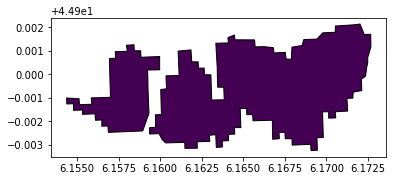

In [36]:
df_ref.plot(edgecolor='k', column='area');

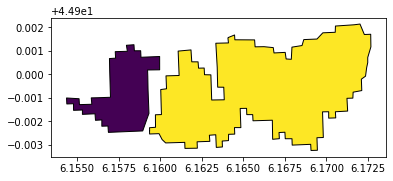

In [37]:
pb_rgi7 = rgi7.iloc[list(not_found.keys())]
pb_rgi7.plot(edgecolor='k', column='area');

**Conclusion: there is no problem in GLIMS!!!**